In [1]:
!nvidia-smi

Sun Mar 23 11:55:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:38:00.0 Off |                    0 |
| N/A   24C    P8             12W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/projects/football


In [29]:
import os

# Create the directory if it doesn't exist
save_dir = f"{HOME}/app/test_data/raw"
os.makedirs(save_dir, exist_ok=True)

# Download videos to the specified directory
!gdown -O "{save_dir}/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "{save_dir}/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "{save_dir}/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "{save_dir}/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "{save_dir}/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /home/ubuntu/projects/football/app/test_data/raw/0bfacc_0.mp4
100%|███████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /home/ubuntu/projects/football/app/test_data/raw/2e57b9_0.mp4
100%|██████████████████████████████████████| 21.1M/21.1M [00:00<00:00, 30.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /home/ubuntu/projects/football/app/test_data/raw/08fd33_0.mp4
100%|███████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /home/ubuntu/projects/football/app/test_data/raw/573e61_0.mp4
100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 46.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4

In [2]:
# !pip install -q ultralytics roboflow

In [3]:
from roboflow import Roboflow
# from google.colab import userdata
from IPython.display import Image

In [4]:
from dotenv import load_dotenv

env_path = f"{HOME}/.env"
load_dotenv(dotenv_path=env_path)
ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")


In [5]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("yolov11")

loading Roboflow workspace...


loading Roboflow project...


In [6]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

## Model Training

In [7]:
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    # Set default CUDA device
    torch.cuda.set_device(0)
    # Display memory information
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
else:
    print("CUDA is not available. Training will use CPU only.")

CUDA available: True
CUDA device count: 4
CUDA device name: NVIDIA L4
CUDA version: 12.4
Total GPU memory: 23.57 GB
Allocated GPU memory: 0.00 GB
Reserved GPU memory: 0.00 GB


In [ ]:
# Install PyTorch with the right CUDA version
print("\nInstallation command for PyTorch with CUDA 12.x support:")
print("!pip3 install torch torchvision torchaudio --upgrade --force-reinstall --index-url https://download.pytorch.org/whl/cu121")

PyTorch CUDA version: None


In [9]:
os.environ["PYTHONHASHSEED"] = "0"  # Disable hash randomization

In [9]:
!export CUDA_LAUNCH_BLOCKING=1

In [7]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
# model = YOLO("yolo12x.pt")
model = YOLO("yolo11x.pt")

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data=f"{dataset.location}/data.yaml", epochs=50, imgsz=1400, batch=16,
                      device=[0,1,2,3], project="app/models/yolo11", name="yolo11_football", plots=True, lr0=1e-3,
                      )

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
                                                       CUDA:1 (NVIDIA L4, 22478MiB)
                                                       CUDA:2 (NVIDIA L4, 22478MiB)
                                                       CUDA:3 (NVIDIA L4, 22478MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/home/ubuntu/projects/football/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1400, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=app/models/yolo11, name=yolo11_football, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None,

train: Scanning /home/ubuntu/projects/football/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]
val: Scanning /home/ubuntu/projects/football/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to app/models/yolo11/yolo11_football/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 1408 train, 1408 val
Using 32 dataloader workers
Logging results to app/models/yolo11/yolo11_football
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      18.9G       1.16      3.467     0.9652        108       1408: 100%|██████████| 19/19 [00:19<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all         49       1174          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      19.5G     0.9893      1.036     0.9578        126       1408: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


                   all         49       1174          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      19.7G     0.9938     0.8133     0.9632         61       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


                   all         49       1174          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      19.7G      1.032     0.8717     0.9529         78       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


                   all         49       1174     0.0122     0.0753    0.00738    0.00526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      19.7G       1.13      0.863     0.9804        116       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


                   all         49       1174      0.559      0.447      0.367      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      19.8G      1.053     0.7354      1.005         92       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


                   all         49       1174      0.453      0.359      0.261      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      19.5G      1.017      0.744     0.9875         62       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


                   all         49       1174      0.473      0.597      0.409      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      19.8G     0.9948     0.6433     0.9576         77       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.786      0.689      0.739      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      19.3G      0.972     0.6257     0.9756         67       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


                   all         49       1174      0.827       0.69      0.795      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      19.7G     0.9179     0.5709     0.9349        152       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all         49       1174      0.746      0.693      0.719      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      19.4G      0.964     0.5928     0.9555         82       1408: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.745       0.61      0.667      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      19.3G     0.9733     0.5877     0.9431         64       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


                   all         49       1174      0.773       0.78      0.754      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      19.5G     0.9007     0.5571     0.9146         88       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.877      0.783      0.827      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      19.7G     0.8669     0.5095     0.9065         54       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.889      0.743      0.838      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      19.8G      0.858     0.4984     0.9122         87       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.822      0.723      0.833      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      19.6G     0.8095     0.4783     0.9013         50       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


                   all         49       1174      0.839      0.821       0.87      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      19.5G     0.8316     0.4934     0.9133         94       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


                   all         49       1174      0.833        0.8      0.833       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      19.7G     0.8244      0.488     0.9103         56       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all         49       1174      0.862      0.799      0.871      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      19.8G     0.8197     0.4594     0.9028         87       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


                   all         49       1174       0.81      0.793      0.859      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      19.5G     0.7941     0.4517       0.87        120       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


                   all         49       1174      0.892      0.808      0.859      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      19.6G     0.7704     0.4391     0.8652        154       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.808      0.794      0.847      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      19.7G     0.7833     0.4335      0.883         62       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all         49       1174      0.876      0.811      0.869      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      19.5G     0.7729     0.4314     0.8794         91       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


                   all         49       1174      0.821      0.855      0.879      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      19.7G     0.7683     0.4427     0.8893        181       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


                   all         49       1174      0.827      0.821      0.877      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      19.8G     0.7948     0.4301     0.8861         49       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174       0.87      0.825      0.886      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      19.6G     0.7802     0.4291      0.881         90       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174       0.93      0.833      0.878      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      19.4G     0.8017     0.4185     0.8719        137       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         49       1174      0.926       0.83      0.886      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      19.6G     0.7536     0.4048      0.891         82       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.903      0.829      0.882      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      19.8G     0.7549     0.4113     0.8766        110       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.877      0.854      0.875      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      19.5G     0.7272     0.3855     0.8818         92       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.867      0.874       0.89      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      19.4G     0.7249     0.3961     0.8718        134       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         49       1174      0.891      0.872      0.906      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      19.7G     0.7029     0.3826     0.8643         70       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.918      0.837      0.898      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      19.2G      0.774     0.4075     0.8765         98       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         49       1174      0.901      0.851       0.89      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      19.7G     0.7551     0.3966     0.8659         65       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all         49       1174      0.895      0.831      0.881      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      19.8G     0.7305     0.3799     0.8612         62       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all         49       1174      0.911       0.83      0.891       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      19.5G     0.6931     0.3627     0.8489        117       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         49       1174      0.902      0.832      0.892      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      19.5G     0.7111       0.37     0.8687        106       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


                   all         49       1174       0.93      0.836      0.893      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      19.6G     0.7129     0.3627     0.8592        126       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.885      0.855      0.903      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      19.9G     0.6965     0.3561     0.8713        114       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.901      0.838      0.903      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      19.5G      0.675     0.3452     0.8623         93       1408: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


                   all         49       1174      0.852      0.888      0.904      0.658
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      19.5G     0.6625     0.3456     0.8647         67       1408: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all         49       1174      0.897      0.844      0.893       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      19.7G     0.6625     0.3356     0.8785         69       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all         49       1174      0.886      0.875       0.91      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      19.8G     0.6302     0.3152     0.8519         73       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.933      0.839      0.899      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      19.6G      0.631     0.3235     0.8565         73       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


                   all         49       1174      0.867      0.897      0.916      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      19.5G     0.6493     0.3219     0.8481         71       1408: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all         49       1174      0.923      0.841      0.902      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      19.7G     0.6366     0.3113     0.8469         68       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all         49       1174      0.958      0.826      0.923      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      19.5G     0.6342      0.313       0.85         71       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         49       1174      0.905      0.868      0.919      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      19.7G      0.601     0.2943     0.8472         73       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174       0.86      0.892      0.907      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      19.4G     0.6273     0.3021     0.8422         72       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


                   all         49       1174      0.875      0.892      0.905      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      19.7G     0.6078     0.2932     0.8568         68       1408: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


                   all         49       1174      0.898      0.879      0.911       0.66

50 epochs completed in 0.363 hours.
Optimizer stripped from app/models/yolo11/yolo11_football/weights/last.pt, 114.6MB
Optimizer stripped from app/models/yolo11/yolo11_football/weights/best.pt, 114.6MB

Validating app/models/yolo11/yolo11_football/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
                                                       CUDA:1 (NVIDIA L4, 22478MiB)
                                                       CUDA:2 (NVIDIA L4, 22478MiB)
                                                       CUDA:3 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


                   all         49       1174      0.957      0.826      0.923      0.665
                  ball         45         45      0.964        0.6      0.776      0.354
            goalkeeper         38         39      0.952      0.744       0.94      0.743
                player         49        973      0.978      0.985      0.993      0.838
               referee         49        117      0.936      0.974      0.984      0.727
Speed: 0.7ms preprocess, 73.8ms inference, 0.1ms loss, 1.6ms postprocess per image
Results saved to app/models/yolo11/yolo11_football


In [8]:
import ultralytics
from ultralytics.utils.downloads import safe_download
ultralytics.checks()

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
Setup complete ✅ (48 CPUs, 181.8 GB RAM, 21.0/122.9 GB disk)
Setup complete ✅ (48 CPUs, 181.8 GB RAM, 21.0/122.9 GB disk)


In [17]:
# !git clone https://github.com/ultralytics/ultralytics
from sahi.utils.file import download_from_url
from sahi.utils.ultralytics import download_yolo11n_model
from sahi import AutoDetectionModel

# Download YOLO11 model
model_path = f"{HOME}/app/models/yolo11/yolo11_football/weights/best.pt"
# download_yolo11n_model(model_path)


detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.45,
    device="cuda",  # or 'cuda:0'
)

In [ ]:
from PIL import Image
import numpy as np
from IPython.display import Image as IPythonImage  # For displaying in notebooks

# Load the image
image = Image.open(image_path)

# Resize image to 1408 (matching the model's training size)
resized_image = image.resize((1408, 1408))

# Save the resized image to use with SAHI
resized_image_path = f"{HOME}/app/test_data/raw/capitano_masr1_resized.png"
resized_image.save(resized_image_path)

### Get standard prediction

In [36]:
from sahi.predict import get_prediction
# With an image path
# result = get_prediction(resized_image_path, detection_model)
# # Export visualization
# result.export_visuals(export_dir="app/test_data/predicted/yolo11/")
video_path = f"{HOME}/app/test_data/raw/121364_0.mp4"

# Run inference with the YOLO12n model on the 'bus.jpg' image
results = model(video_path, conf=0.35, imgsz=1408, augment=True,
                project=f"{HOME}/app/test_data/predicted/yolo11",
                device="cuda", save=True)
# IPythonImage(f"{HOME}/app/test_data/predicted/sahi/prediction_visual.png")



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/750) /home/ubuntu/projects/football/app/test_data/raw/121364_0.mp4: 800x1408 1 ball, 2 goalkeepers, 24 players, 2 referees, 101.5ms
video 1/1 (frame 2/750) /home/ubuntu/projects/football/app/test_data/raw/121364_0.mp4: 800x1408 1 ball, 2 goalkeepers, 24 players, 2 referees, 102.8ms
video 1/1 (frame 3/750) /home/ubuntu/projects/football/app/test_data/raw/121364_0.mp4: 800x1408 1 ball, 2 goalkeepers, 25 players, 2 referees, 101.7ms
vid

### Sahi prediction

#### Predict on a single image

In [ ]:
from sahi.predict import get_sliced_prediction


# Apply sliced prediction on the resized image
result = get_sliced_prediction(
    resized_image_path,
    detection_model,
    # slice_height=720,
    # slice_width=720,
    # overlap_height_ratio=0.2,
    # overlap_width_ratio=0.2
)

# Export visualization
result.export_visuals(export_dir="app/test_data/predicted/sahi_yolo11/")
# Image("app/test_data/predicted/sahi/prediction_visual.png")
# IPythonImage(f"{HOME}/app/test_data/predicted/sahi/prediction_visual.png")

Performing prediction on 1 slices.


#### Predict on video

In [34]:
from sahi.predict import predict

predict(
detection_model = detection_model,
source='app/test_data/raw/121364_0.mp4',
# slice_height=256,
# slice_width=256,
# overlap_height_ratio=0.2,
# overlap_width_ratio=0.2,
return_dict=True,
view_video=False,
# frame_skip_interval=20,
model_confidence_threshold=0.45,
verbose=0,
name="app/test_data/predicted/sahi_yolo11/",
)

Performing inference on video frames:   0%|          | 0/750 [00:00<?, ?it/s]

Performing inference on video frames: 100%|██████████| 750/750 [22:42<00:00,  1.82s/it]


=========================== Video Ended ===========================
Prediction results are successfully exported to runs/predict/app/test_data/predicted/sahi_yolo11


{'export_dir': PosixPath('runs/predict/app/test_data/predicted/sahi_yolo11')}

In [8]:
import torch

# Clear cached memory on the NVIDIA GPU
torch.cuda.empty_cache()
print("Cleared NVIDIA GPU cache memory")

Cleared NVIDIA GPU cache memory


In [16]:
%%markdown
## Validation of the model

## Validation of the model


In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/app/models/yolo11_football_v2/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/home/ubuntu/projects/sure-football-analysis
Ultralytics 8.3.78 🚀 Python-3.13.2 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Scanning /home/ubuntu/projects/sure-football-analysis/football-players-dete
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         49       1174      0.949       0.86      0.903      0.671
                  ball         45         45      0.891      0.644      0.693      0.333
            goalkeeper         38         39      0.944      0.864      0.946      0.752
                player         49        973      0.986      0.984      0.993      0.859
               referee         49        117      0.974      0.947      0.979       0.74
Speed: 11.7ms preprocess, 105.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [10]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/app/models/yolo11/yolo11_football/weights/best.pt data={dataset.location}/data.yaml imgsz=1408

/home/ubuntu/projects/football
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Scanning /home/ubuntu/projects/football/football-players-detection-12/valid
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         49       1174      0.955      0.821      0.916      0.676
                  ball         45         45      0.956      0.578      0.749       0.36
            goalkeeper         38         39      0.951      0.744      0.939      0.755
                player         49        973      0.977      0.988      0.993      0.854
               referee         49        117      0.934      0.975      0.984      0.737
Speed: 13.0ms preprocess, 139.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Predict

In [12]:
!yolo detect predict model={HOME}/app/models/yolo11/yolo11_football/weights/best.pt source={HOME}/app/test_data/raw/capitano_masr1.png imgsz=1408 conf=0.32

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs

image 1/1 /home/ubuntu/projects/football/app/test_data/raw/capitano_masr1.png: 736x1408 2 balls, 11 players, 49.7ms
Speed: 9.1ms preprocess, 49.7ms inference, 111.5ms postprocess per image at shape (1, 3, 736, 1408)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [32]:
%%markdown

## Predict on image


## Predict on image


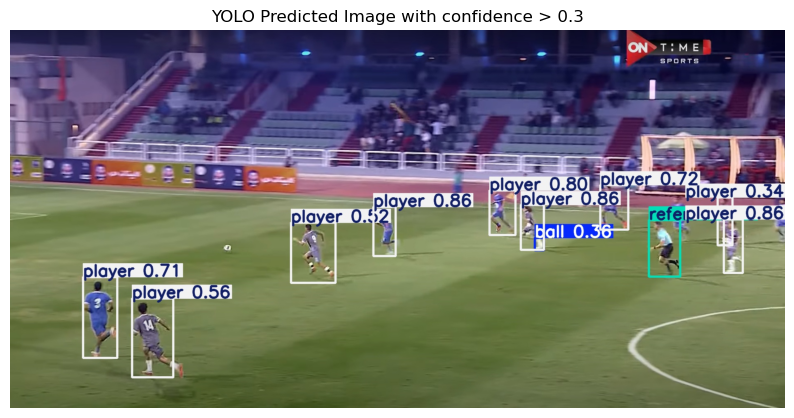

In [29]:
predicted_img_path = "runs/detect/predict2/ss1.jpg"

# Open and display the predicted image
predicted_img = Image.open(predicted_img_path)
plt.figure(figsize=(10, 8))
plt.imshow(predicted_img)
plt.axis("off")  # Hide axes for a cleaner look
plt.title("YOLO Predicted Image with confidence > 0.3")
plt.show()


In [33]:
%%markdown

## Predict on video


## Predict on video


In [ ]:
from IPython.display import Video

# Display the video with embedding enabled
video_path = "capitano_masr/sr1.mp4"
Video(video_path, embed=True, width=640, height=480)



In [34]:
!yolo detect predict model={HOME}/runs/detect/train4/weights/best.pt source=capitano_masr/sr1.mp4 imgsz=1280 conf=0.32


Ultralytics 8.3.78 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs

video 1/1 (frame 1/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 50.3ms
video 1/1 (frame 2/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 28.4ms
video 1/1 (frame 3/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 29.5ms
video 1/1 (frame 4/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 28.6ms
video 1/1 (frame 5/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 29.4ms
video 1/1 (frame 6/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 28.5ms
video 1/1 (frame 7/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 29.6ms
video 1/1 (frame 8/367) /home/ec2-user/SageMaker/capitano_masr/sr1.mp4: 640x1280 1 player, 29.2ms
video 1/1 (frame 9/367) /home/ec2-user/SageMak

In [ ]:
video_path = "runs/detect/predict3/sr1.avi"
Video(video_path, embed=True, width=640, height=480)


## Tracking with StrongSort